In [1]:
import glob
import random
from preprocess import *
from torch_geometric.loader import DataLoader

labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}

dataset = []
for label in labels:
    image_paths = glob.glob(f"shapes/{label}/*")
    random.shuffle(image_paths)
    for path in image_paths[:800]:
        data = create_graph_from_contour(path, labels[label])
        dataset.append(data)

In [2]:
from sklearn.model_selection import train_test_split
# データセットの分割
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# データローダーの作成
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"訓練データ数: {len(train_data)}")
print(f"検証データ数: {len(val_data)}")
print(f"テストデータ数: {len(test_data)}")

訓練データ数: 2048
検証データ数: 512
テストデータ数: 640


モデル

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import negative_sampling

class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Encoder, self).__init__()
        # self.conv1 = GraphSAGE(in_channels, hidden_channels, 2)
        # self.conv2 = GraphSAGE(hidden_channels, out_channels * 2, 2)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels * 2)
        self.l1 = nn.Linear(out_channels * 2, out_channels)


    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.l1(x)
        x = global_mean_pool(x, batch)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.decoder(z)

class GNNAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super(GNNAutoencoder, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, latent_channels)
        self.decoder = Decoder(latent_channels, in_channels)

    def forward(self, x, edge_index, batch):
        z = self.encoder(x, edge_index, batch)
        reconstructed = self.decoder(z)
        return reconstructed, z
    
    def recon_loss(self, x, batch, reconstruct, pos_edge_index, neg_edge_index=None):
        x = global_mean_pool(x, batch)
        pos_loss = F.mse_loss(x, reconstruct)
        
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index)
        
        neg_loss = -torch.log(1 - reconstruct + 1e-15).mean()
        
        return pos_loss + neg_loss

# モデルの初期化
in_channels = 2  # 入力特徴量の次元（x, y座標）
hidden_channels = 32
latent_channels = 2
model = GNNAutoencoder(in_channels, hidden_channels, latent_channels)

# オプティマイザの設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

訓練

In [52]:
# 訓練ループ
def train(model, optimizer):
    model.train()

    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        reconstructed, z = model(data.x, data.edge_index, data.batch)
        # loss = F.mse_loss(reconstructed, data.x)
        loss = model.recon_loss(data.x, data.batch, reconstructed, data.edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 評価関数
def test(model, loader):
    model.eval()

    total_loss = 0
    for data in loader:
        with torch.no_grad():
            reconstructed, z = model(data.x, data.edge_index, data.batch)
            # loss = F.mse_loss(reconstructed, data.x)
            loss = model.recon_loss(data.x, data.batch, reconstructed, data.edge_index)
            total_loss += loss.item()
    return total_loss / len(loader.dataset), z

# 訓練の実行
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model, optimizer)
    if (epoch + 1) % 2 == 0:
        test_loss, _ = test(model, val_loader)
        print(f'Epoch: {epoch+1:03d}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')

# 最終的な潜在表現の取得
_, latent_representation = test(model, val_loader)
print("Latent representation shape:", latent_representation.shape)

Epoch: 002, Train Loss: 0.2544, Test Loss: 0.0080
Epoch: 004, Train Loss: 0.2543, Test Loss: 0.0080
Epoch: 006, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 008, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 010, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 012, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 014, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 016, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 018, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 020, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 022, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 024, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 026, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 028, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 030, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 032, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 034, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 036, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 038, Train Loss: 0.2541, Test Loss: 0.0080
Epoch: 040, Train Loss: 0.2541, Test Loss: 0.0080


In [148]:
test_data = []
for label in labels:
    image_paths = glob.glob(f"shapes/circle/*")
    for path in image_paths[600:610]:
        data = create_graph_from_contour(path, labels[label])
        test_data.append(data)

In [209]:
test_data = [
	create_graph_from_contour("shikaku.png", 1),
	create_graph_from_contour("circle.png", 0),
	create_graph_from_contour("star.png", 2),
	create_graph_from_contour("triangle.png", 3)
]

In [45]:
test_data = [
	create_graph_from_contour("ori_c.png", 0),
	create_graph_from_contour("ori_sq.png", 1),
	create_graph_from_contour("ori_star.png", 2),
	create_graph_from_contour("ori_t.png", 3),
]

[[0.00951601 0.02261642]]


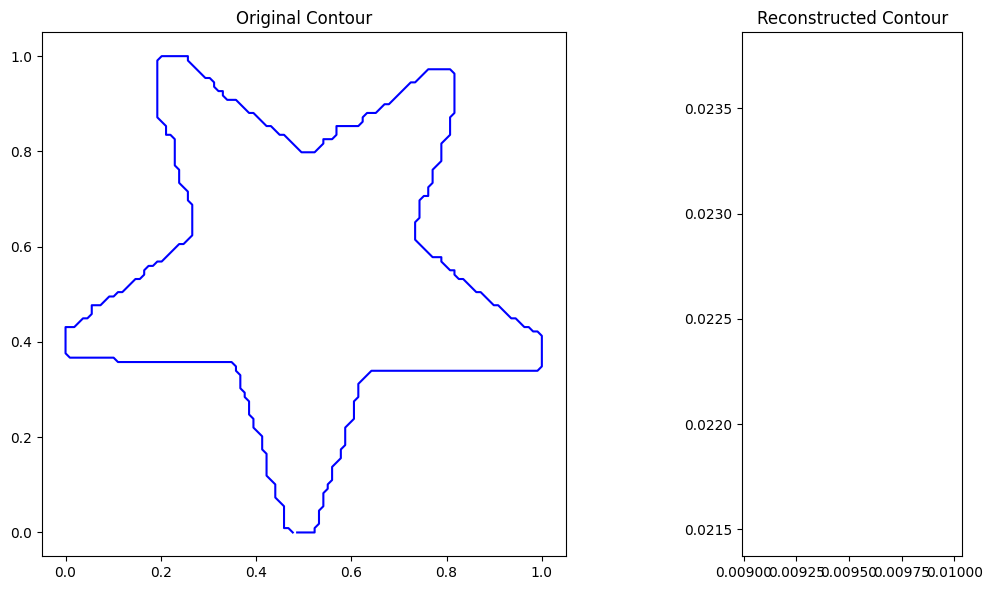

In [53]:
import matplotlib.pyplot as plt

# 再構成と可視化の関数
def reconstruct_and_visualize(model, data, original_shape):
    model.eval()
    with torch.no_grad():
        reconstructed, _ = model(data.x, data.edge_index, data.batch)
    
    # 元のデータと再構成されたデータをnumpy配列に変換
    original = data.x.numpy()
    reconstructed = reconstructed.numpy()
    print(reconstructed)
    
    # 元の形状に戻す
    original = original.reshape(original_shape)
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title('Original Contour')
    ax1.set_aspect('equal')
    
    ax2.plot(reconstructed[:, 0], reconstructed[:, 1], 'r-')
    ax2.set_title('Reconstructed Contour')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# 使用例
# data はPyTorch Geometric のData オブジェクト
# original_shape は元の輪郭データの形状 (例: (100, 2) - 100点の x, y 座標)
i = 2
reconstruct_and_visualize(model, test_data[i], original_shape=test_data[i].x.shape)

In [142]:
i = 3
test_data[i].x

tensor([[0.5140, 0.0000],
        [0.0280, 0.7228],
        [0.0000, 0.8515],
        [0.9813, 1.0000],
        [1.0000, 0.9010],
        [0.6449, 0.1089]])

In [143]:
with torch.no_grad():
        reconstructed, _ = model(test_data[i].x, test_data[i].edge_index)
        print(reconstructed)

tensor([[-0.0037,  0.3343],
        [ 0.2430,  0.5740],
        [ 0.5684,  0.8327],
        [ 0.8876,  0.7576],
        [ 0.7559,  0.6683],
        [ 0.6928,  0.0871]])


## 類似度を求めよう

In [234]:
_, latent_representation = test(model, test_data[1])
latent_representation

tensor([[ 0.4518, -0.1711],
        [ 0.7667, -0.2000],
        [ 0.8830,  0.0237],
        [ 0.7741,  0.4889],
        [ 0.4163,  1.1033],
        [-0.1545,  1.7013],
        [-0.7992,  2.0785],
        [-1.1803,  1.9658],
        [-1.1568,  1.4143],
        [-0.9129,  0.8312],
        [-0.5726,  0.3966],
        [-0.0728,  0.0536]])

In [232]:
latents = []
for data in test_loader:
	latent = test(model, data)
	

array([[ 0.4438531 ,  0.236949  ],
       [ 0.7523881 ,  0.23326537],
       [ 0.74210966,  0.37979308],
       [ 0.4254293 ,  0.90177155],
       [ 0.13075098,  1.3825372 ],
       [-0.2898983 ,  1.7098664 ],
       [-0.67531276,  1.8579142 ],
       [-0.84192145,  1.6146212 ],
       [-1.0397229 ,  1.3400116 ],
       [-0.9530673 ,  1.1447217 ],
       [-0.4272398 ,  0.6909547 ],
       [ 0.02204838,  0.16140103],
       [ 0.22150597,  0.06727308]], dtype=float32)